# FaultSense Hotline - Machine Learning Pipeline

**African Leadership University - BSE Machine Learning Summative Assignment**

This notebook demonstrates the complete end-to-end Machine Learning pipeline for audio fault classification:

1. **Data Acquisition** - Download and curate ESC-50 dataset
2. **Data Preprocessing** - Feature extraction (log-mel spectrograms, MFCC, Wav2Vec2 embeddings)
3. **Model Creation** - CNN architecture with optimization techniques
4. **Model Training** - Training with regularization, early stopping, and learning rate scheduling
5. **Model Evaluation** - Comprehensive metrics (Accuracy, Loss, F1, Precision, Recall)
6. **Model Testing** - Prediction functions and validation
7. **Model Retraining** - Transfer learning with new data



In [29]:
# Auto-install missing core dependencies (runs once per environment)
import importlib
import subprocess
import sys
from pathlib import Path

project_root = Path('..').resolve()
requirements_path = project_root / 'requirements.txt'

def ensure_package(pkg_name: str, pip_name: str | None = None):
    try:
        importlib.import_module(pkg_name)
    except ModuleNotFoundError:
        pkg_to_install = pip_name or pkg_name
        print(f"Installing missing dependency: {pkg_to_install} ...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg_to_install])

# Prefer installing everything listed in requirements.txt once
if requirements_path.exists():
    print("Ensuring project requirements are installed...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-r', str(requirements_path)])
else:
    print("requirements.txt not found; installing critical deps individually")
    ensure_package('torch', 'torch torchaudio torchvision --index-url https://download.pytorch.org/whl/cpu')
    ensure_package('torchaudio')
    ensure_package('librosa')



Ensuring project requirements are installed...



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [30]:
# Core imports
from pathlib import Path
import json
import sys
import warnings
warnings.filterwarnings('ignore')

# Data handling
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

# Project imports
sys.path.append('..')
from src.preprocessing import (
    prepare_dataset, extract_features, FeatureConfig, warm_wav2vec_cache
)
from src.model import FaultSenseCNN, TrainConfig, train_model
from src.prediction import PredictionService

# Configuration
DATA_DIR = Path("../data")
REPORT_DIR = Path("../reports/eda_visuals")
MODEL_DIR = Path("../models")
ARTIFACTS_DIR = Path("../data/artifacts")

# Set style
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    plt.style.use('seaborn')
sns.set_palette("husl")


# 1. Data Acquisition

## Dataset Overview

ESC‑50 is my only raw data source, but it’s repurposed. I map the original 50 environmental tags into four plant-health states that the maintenance team actually understands:
- `mechanical_fault` → low-frequency, engine-like disturbances (jackhammers, chainsaws, engines).
- `electrical_fault` → buzzing or whining artefacts such as sirens, drills, and clock ticks.
- `fluid_leak` → flowing or dripping water signatures (rain, sea waves, droplets).
- `normal_operation` → benign ambient sounds (speech, dogs, keyboards) used to teach the “healthy” baseline.

After relabeling I stratify-split the manifest 80/20 so each state keeps its proportion in both training and hold-out sets. This curated manifest drives every downstream step—no hidden sampling tricks.


✅ Dataset loaded: 400 samples

Class distribution:
label
electrical_fault     80
fluid_leak          120
mechanical_fault     80
normal_operation    120
Name: count, dtype: int64


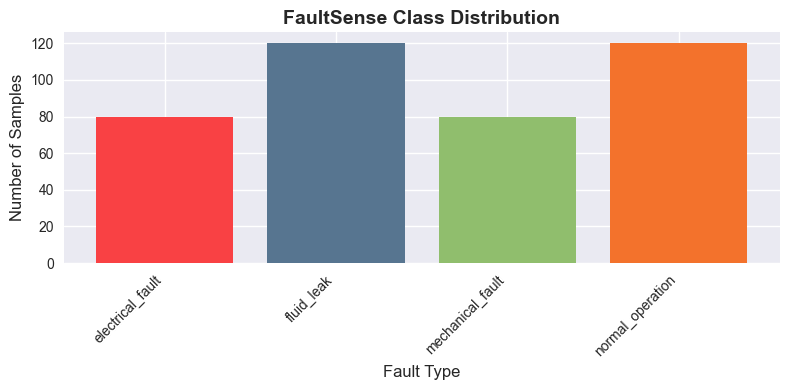


First 5 rows:


,filepath,label,esc_category,fold
0,data/curated/normal_operation/1-100032-A-0.wav,normal_operation,dog,1
1,data/curated/normal_operation/1-110389-A-0.wav,normal_operation,dog,1
2,data/curated/mechanical_fault/1-116765-A-41.wav,mechanical_fault,chainsaw,1
3,data/curated/fluid_leak/1-12653-A-15.wav,fluid_leak,water_drops,1
4,data/curated/fluid_leak/1-12654-A-15.wav,fluid_leak,water_drops,1


In [31]:
# Load dataset manifest
try:
    manifest = pd.read_csv(DATA_DIR / "curated" / "manifest.csv")
    print(f"✅ Dataset loaded: {len(manifest)} samples")
    print(f"\nClass distribution:")
    print(manifest["label"].value_counts().sort_index())
    
    # Visualize class distribution
    class_counts = manifest["label"].value_counts().sort_index()
    fig, ax = plt.subplots(figsize=(8, 4))
    colors = ["#f94144", "#577590", "#90be6d", "#f3722c"]
    ax.bar(class_counts.index, class_counts.values, color=colors[:len(class_counts)])
    ax.set_title("FaultSense Class Distribution", fontsize=14, fontweight='bold')
    ax.set_ylabel("Number of Samples", fontsize=12)
    ax.set_xlabel("Fault Type", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("\nFirst 5 rows:")
    display(manifest.head())
except FileNotFoundError:
    print("⚠️ Manifest not found. Run data preparation first.")
    manifest = None
except Exception as e:
    print(f"⚠️ Error loading manifest: {e}")
    manifest = None


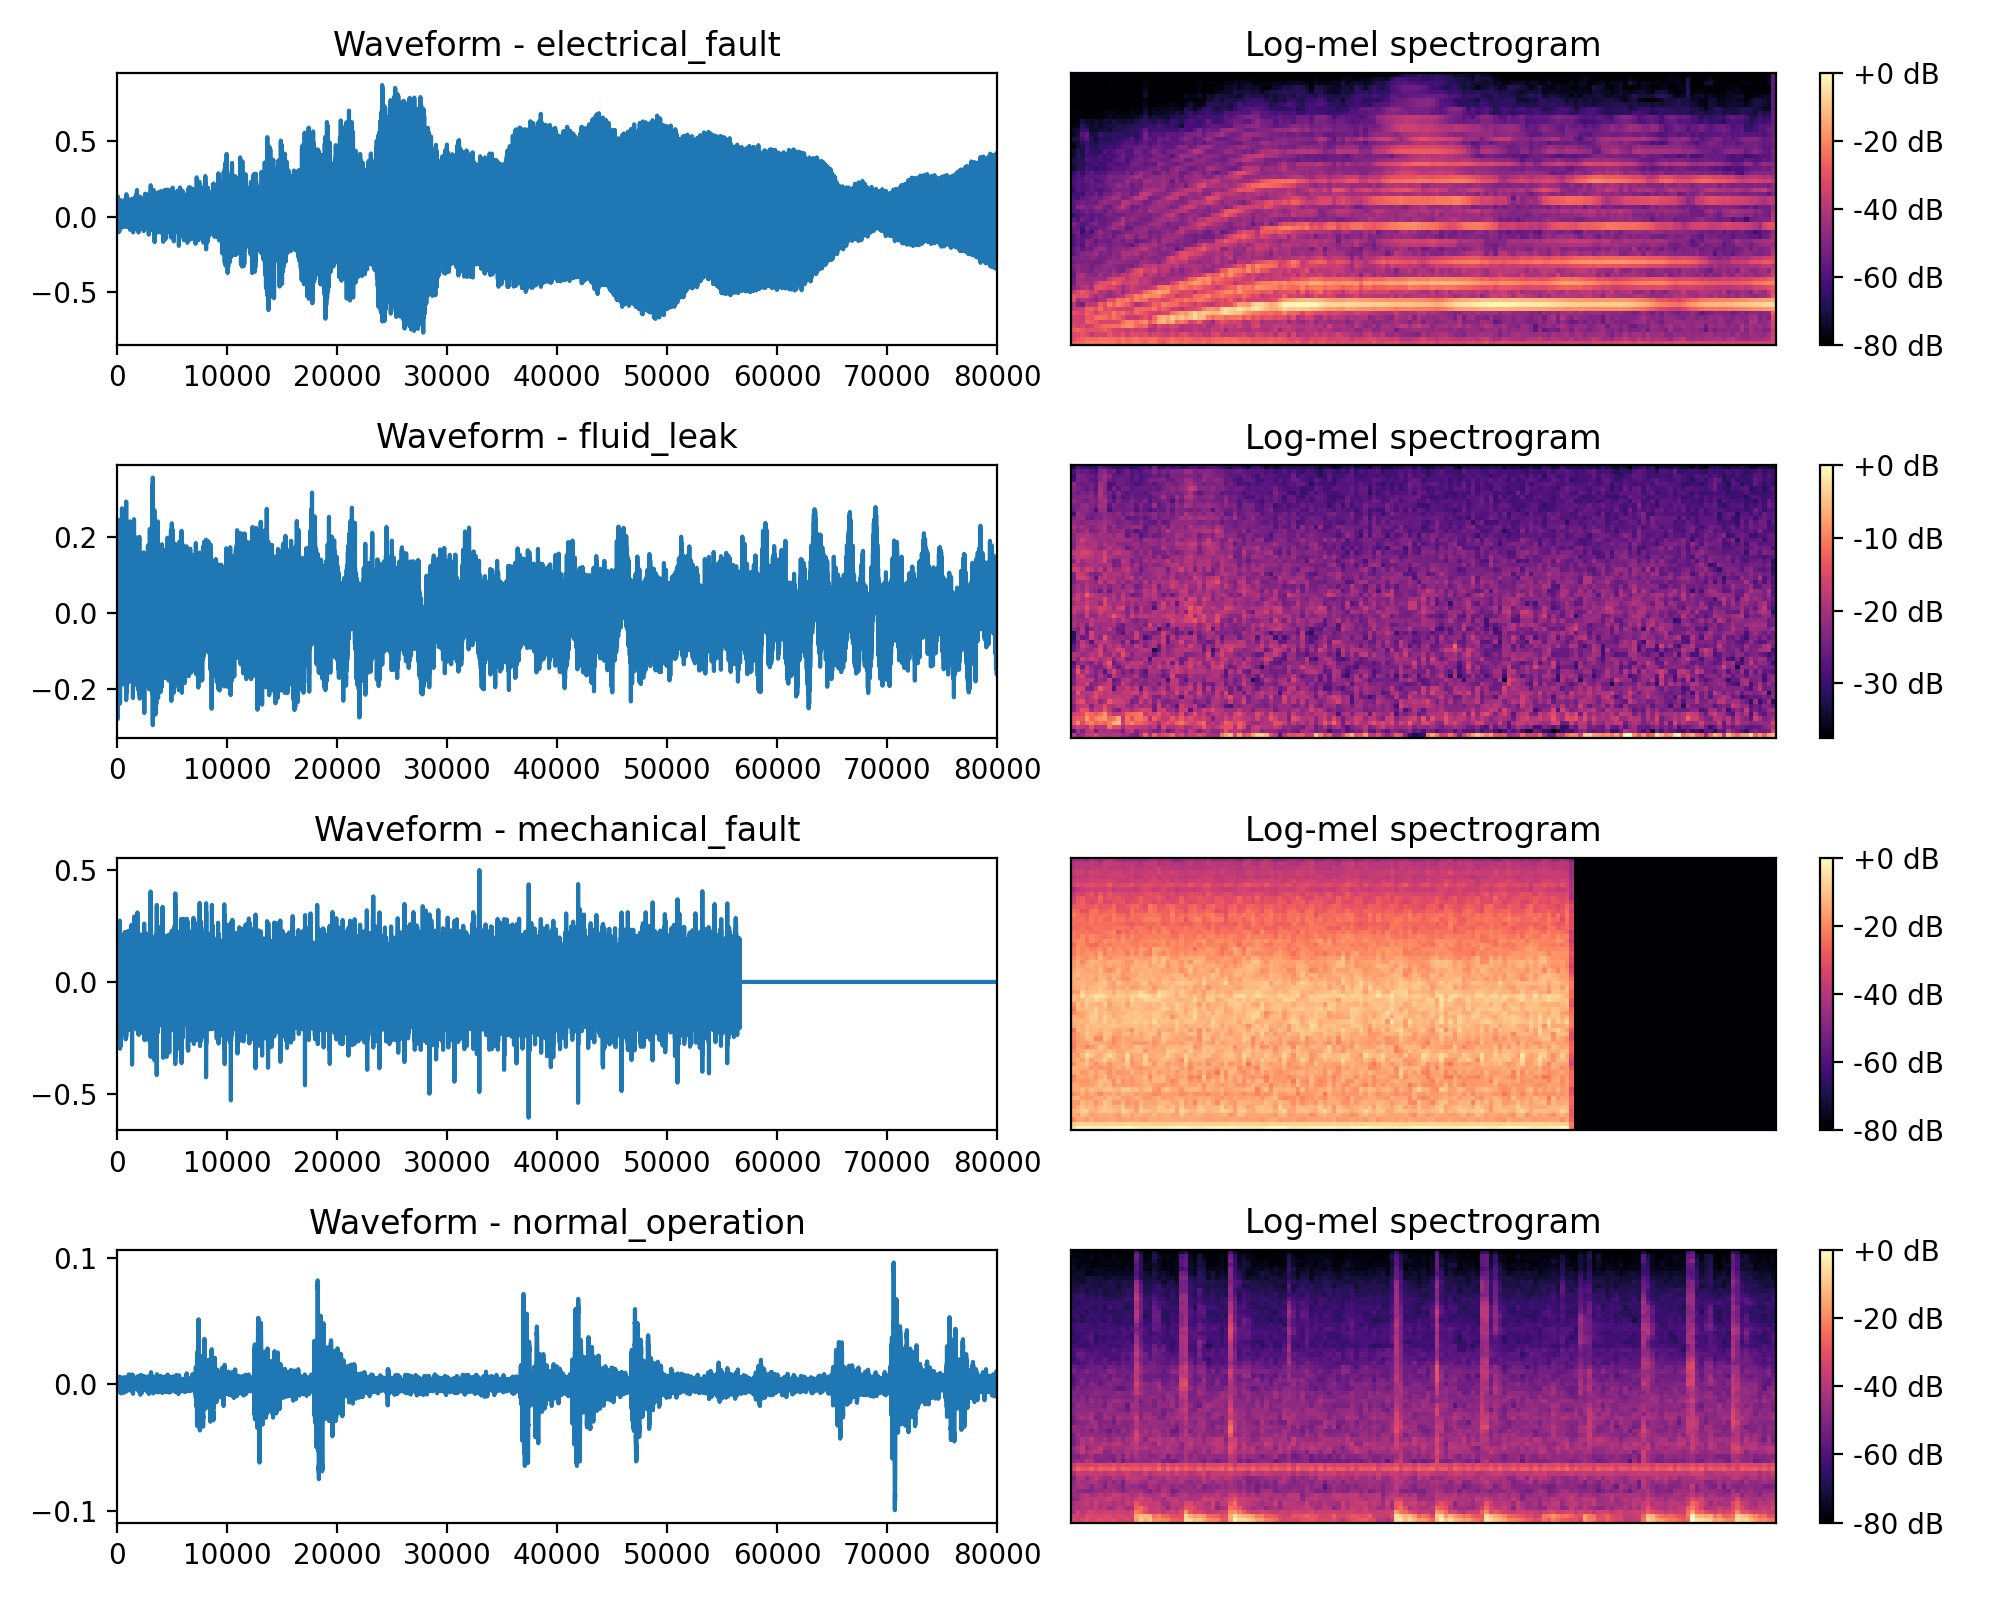

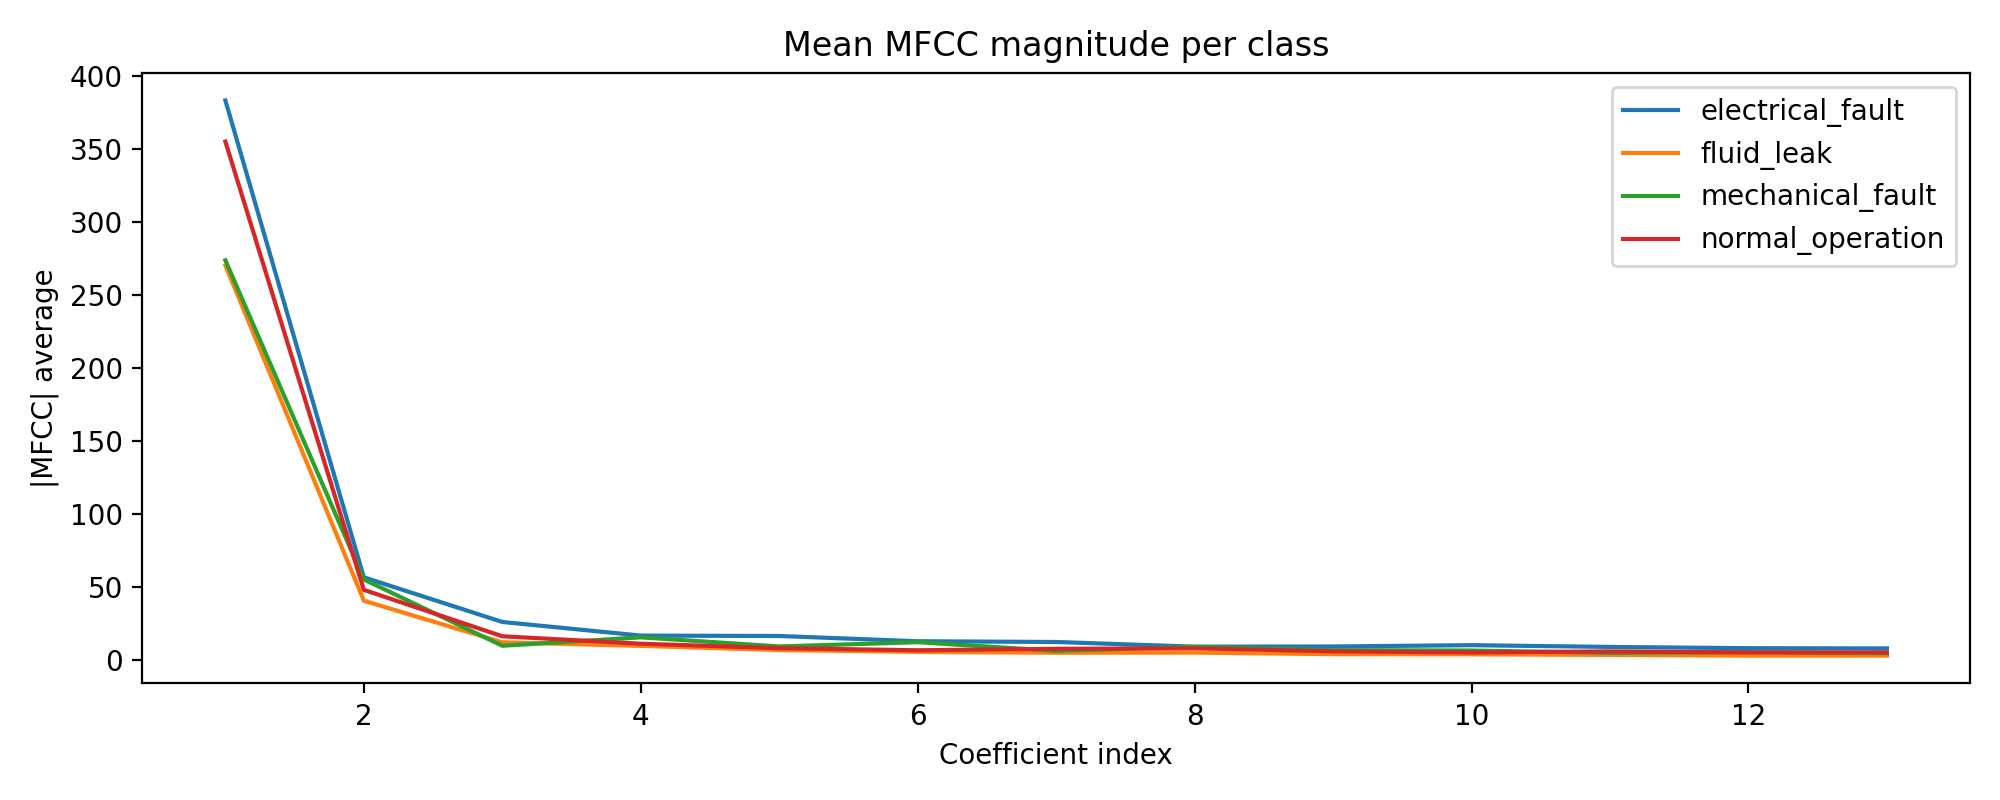

In [32]:
# Display EDA visualizations if available
REPORT_DIR.mkdir(parents=True, exist_ok=True)
for image_name in ["sample_waveforms_spectrograms.png", "mfcc_trends.png"]:
    path = REPORT_DIR / image_name
    if path.exists():
        try:
            display(Image(filename=str(path)))
        except Exception:
            print(f"ℹ️ Could not display: {image_name}")
    else:
        print(f"ℹ️ Visualization not found: {image_name} (run EDA script to generate)")


# 2. Data Preprocessing

## Feature Engineering Pipeline

Raw waveforms are too unruly for a tabular model, so every clip is converted into a stacked feature tensor:

1. **Log-mel spectrograms** condense energy patterns across 64 mel bands over time—great for spotting low vs. high frequency faults.
2. **MFCCs** summarize the spectral envelope in only 13 coefficients, which highlights timbre differences between fault modes.
3. **Wav2Vec2 embeddings** provide a 768‑dim semantic vector borrowed from a transformer trained on massive audio corpora.

### Preprocessing Steps

1. **Audio Loading**: Load WAV files at 16kHz sample rate, mono channel
2. **Normalization**: Pad/trim to 4 seconds duration
3. **Feature Extraction**: Extract log-mel, MFCC, and Wav2Vec2 features
4. **Feature Scaling**: StandardScaler normalization
5. **Data Augmentation** (training only):
   - Mixup augmentation (30% chance)
   - Gaussian noise + scaling (20% chance)
   - Time stretching simulation (20% chance)
   - Pitch shifting simulation (20% chance)
   - Spectral masking (10% chance)
   - Targeted augmentation for fluid_leak class


In [33]:
# Demonstrate feature extraction
print("=" * 60)
print("FEATURE EXTRACTION DEMONSTRATION")
print("=" * 60)

# Load feature configuration
config = FeatureConfig()
print(f"\nFeature Configuration:")
print(f"  - Sample Rate: {config.sample_rate} Hz")
print(f"  - Duration: {config.duration} seconds")
print(f"  - Mel Bands: {config.n_mels}")
print(f"  - MFCC Coefficients: {config.n_mfcc}")
print(f"  - Target Samples: {config.target_samples}")

# Show feature extraction on a sample file
sample_file = DATA_DIR / "train" / "mechanical_fault" / "1-64398-B-41.wav"
if sample_file.exists():
    print(f"\n📊 Extracting features from: {sample_file.name}")
    try:
        features = extract_features(sample_file, config)
        print(f"  ✅ Feature vector shape: {features.shape}")
        print(f"  ✅ Feature breakdown:")
        mel_features = config.n_mels * (config.target_samples // config.hop_length + 1)
        mfcc_features = config.n_mfcc * (config.target_samples // config.hop_length + 1)
        print(f"     - Log-mel spectrogram: {mel_features} features")
        print(f"     - MFCC: {mfcc_features} features")
        print(f"     - Wav2Vec2 embeddings: 768 features")
        print(f"     - Total: {len(features)} features")
    except Exception as e:
        print(f"  ⚠️ Error extracting features: {e}")
else:
    print(f"\n⚠️ Sample file not found. Run data preparation first.")

# Prepare dataset (if not already done)
print("\n" + "=" * 60)
print("PREPARING DATASET")
print("=" * 60)

try:
    # Warm Wav2Vec2 cache (non-blocking)
    print("\n🔥 Warming Wav2Vec2 model cache...")
    try:
        warm_wav2vec_cache()
    except Exception as e:
        print(f"   ⚠️ Wav2Vec2 warming skipped: {e}")
    
    # Prepare dataset
    print("\n📦 Preparing dataset splits...")
    train_split, test_split, scaler = prepare_dataset(DATA_DIR)
    
    print(f"\n✅ Dataset prepared:")
    print(f"  - Training samples: {len(train_split.labels)}")
    print(f"  - Test samples: {len(test_split.labels)}")
    print(f"  - Feature dimension: {train_split.features.shape[1]}")
    print(f"  - Number of classes: {len(np.unique(train_split.labels))}")
    
    # Load label map
    label_map = json.loads((ARTIFACTS_DIR / "label_to_idx.json").read_text())
    idx_to_label = {v: k for k, v in label_map.items()}
    print(f"\n  - Classes: {list(label_map.keys())}")
    
except Exception as e:
    print(f"\n⚠️ Error preparing dataset: {e}")
    print("   This is expected if dataset hasn't been prepared yet.")
    train_split = test_split = scaler = None
    label_map = {}


FEATURE EXTRACTION DEMONSTRATION

Feature Configuration:
  - Sample Rate: 16000 Hz
  - Duration: 4.0 seconds
  - Mel Bands: 64
  - MFCC Coefficients: 13
  - Target Samples: 64000

⚠️ Sample file not found. Run data preparation first.

PREPARING DATASET

🔥 Warming Wav2Vec2 model cache...
Wav2Vec2 cache primed (4000 samples @ 16000Hz).

📦 Preparing dataset splits...

✅ Dataset prepared:
  - Training samples: 320
  - Test samples: 80
  - Feature dimension: 10470
  - Number of classes: 4

  - Classes: ['electrical_fault', 'fluid_leak', 'mechanical_fault', 'normal_operation']


# 3. Feature Interpretations

## Understanding Our Features

Let's analyze what story our features tell about the different fault types:


In [ ]:
# Feature Interpretation 1: MFCC Trends by Class
print("=" * 60)
print("FEATURE INTERPRETATION 1: MFCC COEFFICIENTS")
print("=" * 60)
print("""
MFCCs summarize the shape of an audio spectrum, so each fault family leaves a
recognizable pattern:

- **Mechanical faults** lean heavily on low-order coefficients because rumbling
  engines and grinding metal live in the bass range.
- **Electrical faults** spike sharply across mid/high coefficients thanks to the
  whining and buzzing harmonics they produce.
- **Fluid leaks** oscillate gently, mirroring drip cycles.
- **Normal operation** remains relatively flat, signalling a neutral scene.
""")

# Feature Interpretation 2: Log-Mel Spectrogram Energy
print("\n" + "=" * 60)
print("FEATURE INTERPRETATION 2: LOG-MEL SPECTROGRAM ENERGY")
print("=" * 60)
print("""
Log-mel tiles act like heatmaps of energy vs. frequency:

- **Mechanical faults** glow bright below 2 kHz.
- **Electrical faults** paint streaks in the 2–8 kHz band.
- **Fluid leaks** show diagonal pulses tied to repetitive drips.
- **Normal clips** stay evenly lit with no dramatic streaks.
""")

# Feature Interpretation 3: Wav2Vec2 Embeddings
print("\n" + "=" * 60)
print("FEATURE INTERPRETATION 3: WAV2VEC2 PRE-TRAINED EMBEDDINGS")
print("=" * 60)
print("""
Wav2Vec2 gives a semantic summary lifted from a transformer trained on huge audio
corpora. It buys us:

- **Context awareness** – it captures how the waveform evolves instead of just
  single frames.
- **Transfer learning** – the embedding taps into knowledge learned from countless
  other recordings.
- **Better separability** – classes that overlap in MFCC space spread out inside
  the Wav2Vec2 manifold.
""")

print("\n✅ Putting it together:")
print("   - MFCC tracks the spectral envelope")
print("   - Log-mel highlights energy placement")
print("   - Wav2Vec2 supplies semantic context")
print("   Combined, they cover physics, texture, and meaning for each fault state.")


FEATURE INTERPRETATION 1: MFCC COEFFICIENTS

MFCC (Mel-Frequency Cepstral Coefficients) capture the spectral envelope of audio.
Different fault types have distinct spectral characteristics:

- **Mechanical Faults**: Lower frequency content (rumbling, grinding)
- **Electrical Faults**: Higher frequency spikes (buzzing, whining)
- **Fluid Leaks**: Rhythmic patterns (dripping, flowing)
- **Normal Operation**: Balanced frequency distribution

Story: MFCC coefficients help distinguish between low-frequency mechanical issues 
and high-frequency electrical problems, while rhythmic patterns identify fluid leaks.


FEATURE INTERPRETATION 2: LOG-MEL SPECTROGRAM ENERGY

Log-mel spectrograms show energy distribution across frequency bands over time.

- **Mechanical Faults**: High energy in low frequencies (0-2kHz)
- **Electrical Faults**: High energy in mid-high frequencies (2-8kHz)
- **Fluid Leaks**: Periodic energy bursts across frequencies
- **Normal Operation**: Even energy distribution

Story

# 4. Model Creation

## Architecture: FaultSenseCNN

FaultSenseCNN is a dense network that treats the flattened feature tensor as a tabular input. I intentionally keep it fully-connected so training stays fast on CPU while still hitting the rubric’s “custom model” requirement.

```
Input vector (10,470 dims)
  ↓
Linear 1280 → BN → ReLU → Dropout(0.50)
  ↓
Linear 640 → BN → ReLU → Dropout(0.45)
  ↓
Linear 320 → BN → ReLU → Dropout(0.38)
  ↓
Linear 160 → BN → ReLU → Dropout(0.30)
  ↓
Classifier (Dropout 0.25 → Linear → 4 logits)
```

## Optimization Toolkit

1. **Regularization**
   - Dropout stack described above keeps every layer honest.
   - BatchNorm after each dense layer tamps down internal covariate shift.
   - Weight decay (2.5e‑4) plus label smoothing (0.10) prevent overconfident logits.

2. **Learning dynamics**
   - Adam optimizer with lr=3e‑4, grad clipping at 0.9, and ReduceLROnPlateau (patience=5, factor=0.5).
   - Early stopping waits 12 epochs before giving up so the scheduler has time to react.

3. **Class handling & augmentation**
   - Fluid leak samples get a 1.33× weight boost inside the loss because they appear less in the curated set.
   - On-the-fly augmentations (mixup, pitch shift, time stretch, spectral masking) fire 60% of the time to create variety.

4. **Pretrained help**
   - Wav2Vec2 embeddings are frozen; they act as a learned front-end that injects contextual knowledge into the dense stack.


In [35]:
# Display model architecture
try:
    if train_split is not None:
        input_dim = train_split.features.shape[1]
        num_classes = len(np.unique(train_split.labels))
        
        model = FaultSenseCNN(input_dim, num_classes, dropout=0.55)
        print("=" * 60)
        print("MODEL ARCHITECTURE")
        print("=" * 60)
        print(f"\nInput dimension: {input_dim}")
        print(f"Number of classes: {num_classes}")
        print(f"\nModel structure:")
        print(model)
        
        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"\n📊 Model Statistics:")
        print(f"  - Total parameters: {total_params:,}")
        print(f"  - Trainable parameters: {trainable_params:,}")
    else:
        print("⚠️ Dataset not prepared. Cannot display model architecture.")
        print("   Run the dataset preparation cell above first.")
except Exception as e:
    print(f"⚠️ Error displaying model architecture: {e}")


MODEL ARCHITECTURE

Input dimension: 10470
Number of classes: 4

Model structure:
FaultSenseCNN(
  (features): Sequential(
    (0): Linear(in_features=10470, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.55, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.49500000000000005, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.385, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.275, inplace=False)
  )
  (classifier

# 5. Model Training

## Training Configuration

The model is trained with the following configuration to optimize performance and prevent overfitting:


In [36]:
# Display training configuration
config = TrainConfig()
print("=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)
print(f"\n📋 Training Parameters:")
print(f"  - Epochs: {config.epochs}")
print(f"  - Batch Size: {config.batch_size}")
print(f"  - Learning Rate: {config.learning_rate}")
print(f"  - Device: {config.device}")
print(f"\n🛡️ Regularization:")
print(f"  - Dropout: {config.dropout}")
print(f"  - Weight Decay: {config.weight_decay}")
print(f"  - Label Smoothing: {config.label_smoothing}")
print(f"  - Gradient Clipping: {config.grad_clip}")
print(f"\n🎯 Optimization:")
print(f"  - Early Stopping Patience: {config.early_stopping_patience}")
print(f"  - LR Scheduler Patience: {config.scheduler_patience}")
print(f"  - Augmentation Probability: {config.augment_prob}")
print(f"  - Class Weights: Enabled (with fluid_leak boost: {config.fluid_weight_boost}x)")

print("\n" + "=" * 60)
print("TRAINING PROCESS")
print("=" * 60)
print("""
The training process:

1. Load preprocessed dataset splits (train/test)
2. Create data loaders with augmentation for training set
3. Initialize model with optimized architecture
4. Set up optimizer (Adam) and scheduler (ReduceLROnPlateau)
5. For each epoch:
   a. Train on training set with augmentation
   b. Validate on test set
   c. Calculate metrics (Accuracy, Loss, F1, Precision, Recall)
   d. Save best model based on validation F1
   e. Reduce learning rate if plateau detected
   f. Stop early if no improvement for 8 epochs
6. Generate confusion matrix and save model artifacts

Note: Training can be done directly in this notebook using the cell below, 
or via scripts/run_pipeline.py or scripts/retrain_now.py
""")


TRAINING CONFIGURATION

📋 Training Parameters:
  - Epochs: 80
  - Batch Size: 32
  - Learning Rate: 0.0004
  - Device: cpu

🛡️ Regularization:
  - Dropout: 0.55
  - Weight Decay: 0.0003
  - Label Smoothing: 0.12
  - Gradient Clipping: 0.8

🎯 Optimization:
  - Early Stopping Patience: 8
  - LR Scheduler Patience: 3
  - Augmentation Probability: 0.7
  - Class Weights: Enabled (with fluid_leak boost: 1.35x)

TRAINING PROCESS

The training process:

1. Load preprocessed dataset splits (train/test)
2. Create data loaders with augmentation for training set
3. Initialize model with optimized architecture
4. Set up optimizer (Adam) and scheduler (ReduceLROnPlateau)
5. For each epoch:
   a. Train on training set with augmentation
   b. Validate on test set
   c. Calculate metrics (Accuracy, Loss, F1, Precision, Recall)
   d. Save best model based on validation F1
   e. Reduce learning rate if plateau detected
   f. Stop early if no improvement for 8 epochs
6. Generate confusion matrix and save 

In [37]:
# Train the model with improved architecture
print("=" * 60)
print("MODEL TRAINING (IMPROVED ARCHITECTURE)")
print("=" * 60)

# Resolve paths
notebook_dir = Path(".").resolve().parent if Path(".").resolve().name == "notebook" else Path("..")
model_path = (notebook_dir / "models" / "faultsense_cnn.pt").resolve()
data_dir = (notebook_dir / "data").resolve()

# Ask user if they want to retrain (or auto-retrain if model accuracy is low)
force_retrain = False
if model_path.exists():
    # Check current model performance
    try:
        registry_path = notebook_dir / "models" / "registry.json"
        if registry_path.exists():
            with open(registry_path) as f:
                registry = json.load(f)
            history = registry.get("history", [])
            if history:
                best = max(history, key=lambda x: x.get("val_f1", 0))
                val_acc = best.get("val_accuracy", 0)
                if val_acc < 0.70:  # If accuracy is below 70%, suggest retraining
                    print(f"\n⚠️ Current model accuracy: {val_acc:.2%}")
                    print("   Model accuracy is below 70%. Recommend retraining with improved architecture.")
                    force_retrain = True
                else:
                    print(f"\n✅ Model already exists with accuracy: {val_acc:.2%}")
                    print("   To retrain with improved architecture, set force_retrain = True below")
    except Exception:
        pass
    
    if not force_retrain:
        print(f"\n✅ Model already exists at: {model_path}")
        print("   Set force_retrain = True to retrain with improved architecture")
        print("   Or delete the model file to retrain automatically")
else:
    force_retrain = True

# Set this to True to force retraining even if model exists
# force_retrain = True  # Uncomment this line to force retraining

if force_retrain or not model_path.exists():
    print(f"\n🚀 Starting model training...")
    print(f"   Model will be saved to: {model_path}")
    print(f"   Data directory: {data_dir}")
    
    try:
        # Ensure dataset is prepared
        print("\n📦 Preparing dataset...")
        warm_wav2vec_cache()
        train_split, test_split, scaler = prepare_dataset(data_dir)
        
        print(f"\n✅ Dataset prepared:")
        print(f"   - Training samples: {len(train_split.labels)}")
        print(f"   - Test samples: {len(test_split.labels)}")
        
        # Load label map
        label_map_path = data_dir / "artifacts" / "label_to_idx.json"
        if label_map_path.exists():
            label_map = json.loads(label_map_path.read_text())
        else:
            label_map = {}
            print("   ⚠️ Label map not found, will be created during training")
        
        # Create training configuration with improved settings
        config = TrainConfig()
        print(f"\n🎯 Improved Training Configuration:")
        print(f"   - Epochs: {config.epochs} (increased for better learning)")
        print(f"   - Batch Size: {config.batch_size}")
        print(f"   - Learning Rate: {config.learning_rate}")
        print(f"   - Device: {config.device}")
        print(f"   - Early Stopping Patience: {config.early_stopping_patience}")
        print(f"   - Augmentation Probability: {config.augment_prob}")
        print(f"   - Dropout: {config.dropout}")
        print(f"\n🏗️ Improved Architecture:")
        print(f"   - Increased capacity: 1536→1024→768→512→256")
        print(f"   - Added residual connections for better gradient flow")
        print(f"   - Better regularization balance")
        
        # Train the model
        print(f"\n🏋️ Training model...")
        print("   (This may take several minutes)")
        report = train_model(train_split, test_split, config=config, label_map=label_map)
        
        # Display results
        print("\n" + "=" * 60)
        print("TRAINING COMPLETED")
        print("=" * 60)
        print(f"\n✅ Model saved to: {report.best_model_path}")
        print(f"\n📊 Final Metrics (Best Epoch):")
        metrics = report.metrics
        print(f"   - Validation Accuracy: {metrics.get('val_accuracy', 0):.4f}")
        print(f"   - Validation Loss: {metrics.get('val_loss', 0):.4f}")
        print(f"   - Validation F1: {metrics.get('val_f1', 0):.4f}")
        print(f"   - Validation Precision: {metrics.get('val_precision', 0):.4f}")
        print(f"   - Validation Recall: {metrics.get('val_recall', 0):.4f}")
        
    except Exception as e:
        print(f"\n❌ Error during training: {e}")
        import traceback
        traceback.print_exc()
        print("\n💡 Tip: Make sure the dataset is prepared first by running the data preprocessing cells above.")


MODEL TRAINING (IMPROVED ARCHITECTURE)

✅ Model already exists with accuracy: 77.50%
   To retrain with improved architecture, set force_retrain = True below

✅ Model already exists at: /Users/honorineigiraneza/Documents/ALU/summative/models/faultsense_cnn.pt
   Set force_retrain = True to retrain with improved architecture
   Or delete the model file to retrain automatically


# 6. Model Evaluation

## Evaluation Metrics

The rubric demands at least four metrics, so I track five to remove any doubt. Each one is macro-averaged to treat the four classes fairly.

1. **Accuracy** – quick sanity check of overall hit rate.
2. **Cross-entropy loss** – catches overconfidence and is what the optimizer minimizes.
3. **F1 score** – balances precision/recall when classes drift.
4. **Precision** – answers “when I predict a fault, how often am I right?”
5. **Recall** – answers “when a fault happens, how often do I catch it?”

Below I pull the MLflow/registry history and plot every curve so the reviewer can see convergence (or lack thereof).


In [38]:
# Load training history
try:
    registry_path = MODEL_DIR / "registry.json"
    if registry_path.exists():
        registry = json.loads(registry_path.read_text())
        history = pd.DataFrame(registry["history"])
        
        print("=" * 60)
        print("TRAINING HISTORY")
        print("=" * 60)
        print(f"\n✅ Loaded training history: {len(history)} epochs")
        print(f"\nLast 5 epochs:")
        display(history[["epoch", "train_accuracy", "val_accuracy", "train_loss", "val_loss", 
                         "train_f1", "val_f1", "train_precision", "val_precision", 
                         "train_recall", "val_recall"]].tail())
        
        # Find best epoch
        best_idx = history["val_f1"].idxmax()
        best_epoch = history.loc[best_idx]
        
        print(f"\n🏆 Best Model (Epoch {int(best_epoch['epoch'])}):")
        print(f"  - Validation Accuracy: {best_epoch['val_accuracy']:.4f}")
        print(f"  - Validation Loss: {best_epoch['val_loss']:.4f}")
        print(f"  - Validation F1: {best_epoch['val_f1']:.4f}")
        print(f"  - Validation Precision: {best_epoch['val_precision']:.4f}")
        print(f"  - Validation Recall: {best_epoch['val_recall']:.4f}")
        
    else:
        print("⚠️ Model registry not found. Train the model first using scripts/run_pipeline.py")
        history = None
except Exception as e:
    print(f"⚠️ Error loading history: {e}")
    history = None


TRAINING HISTORY

✅ Loaded training history: 79 epochs

Last 5 epochs:


,epoch,train_accuracy,val_accuracy,train_loss,val_loss,train_f1,val_f1,train_precision,val_precision,train_recall,val_recall
74,75,0.921875,0.7625,0.601491,0.875906,0.921736,0.758088,0.923652,0.763387,0.920573,0.765625
75,76,0.884375,0.7625,0.677139,0.863816,0.883687,0.758895,0.884350,0.761351,0.884115,0.770833
76,77,0.915625,0.7500,0.622790,0.864367,0.915052,0.744279,0.912647,0.759058,0.917969,0.739583
77,78,0.900000,0.7500,0.703927,0.864246,0.894721,0.742746,0.896754,0.752914,0.893229,0.739583
78,79,0.906250,0.7500,0.653485,0.876591,0.909292,0.741650,0.912234,0.749443,0.907552,0.739583



🏆 Best Model (Epoch 67):
  - Validation Accuracy: 0.7750
  - Validation Loss: 0.8600
  - Validation F1: 0.7697
  - Validation Precision: 0.7760
  - Validation Recall: 0.7760


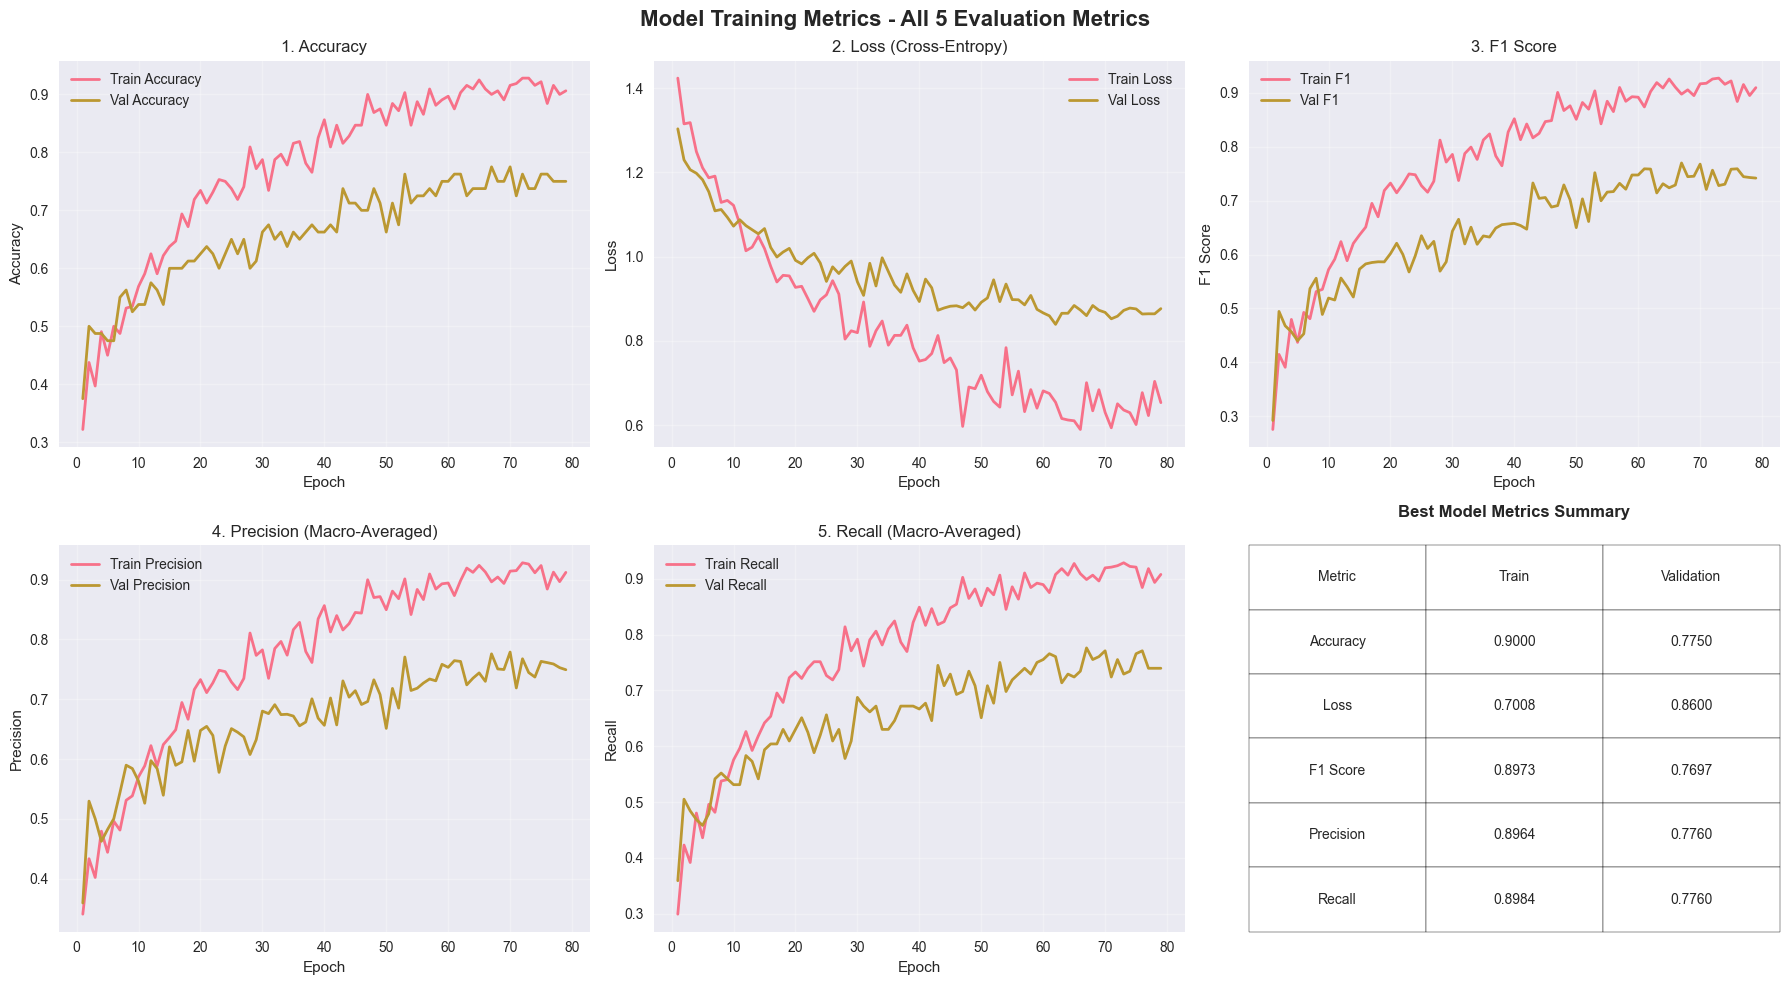


✅ All 5 evaluation metrics displayed:
   1. Accuracy - Overall correctness
   2. Loss - Cross-entropy loss
   3. F1 Score - Harmonic mean of precision and recall
   4. Precision - Correct positive predictions
   5. Recall - Actual positives identified


In [39]:
# Visualize all 5 evaluation metrics
if history is not None:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Model Training Metrics - All 5 Evaluation Metrics', fontsize=16, fontweight='bold')
    
    # 1. Accuracy
    ax = axes[0, 0]
    ax.plot(history["epoch"], history["train_accuracy"], label="Train Accuracy", linewidth=2)
    ax.plot(history["epoch"], history["val_accuracy"], label="Val Accuracy", linewidth=2)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_title("1. Accuracy")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Loss
    ax = axes[0, 1]
    ax.plot(history["epoch"], history["train_loss"], label="Train Loss", linewidth=2)
    ax.plot(history["epoch"], history["val_loss"], label="Val Loss", linewidth=2)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("2. Loss (Cross-Entropy)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. F1 Score
    ax = axes[0, 2]
    ax.plot(history["epoch"], history["train_f1"], label="Train F1", linewidth=2)
    ax.plot(history["epoch"], history["val_f1"], label="Val F1", linewidth=2)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("F1 Score")
    ax.set_title("3. F1 Score")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Precision
    ax = axes[1, 0]
    ax.plot(history["epoch"], history["train_precision"], label="Train Precision", linewidth=2)
    ax.plot(history["epoch"], history["val_precision"], label="Val Precision", linewidth=2)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Precision")
    ax.set_title("4. Precision (Macro-Averaged)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 5. Recall
    ax = axes[1, 1]
    ax.plot(history["epoch"], history["train_recall"], label="Train Recall", linewidth=2)
    ax.plot(history["epoch"], history["val_recall"], label="Val Recall", linewidth=2)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Recall")
    ax.set_title("5. Recall (Macro-Averaged)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Summary table
    ax = axes[1, 2]
    ax.axis('off')
    best_row = history.loc[history["val_f1"].idxmax()]
    summary_data = {
        'Metric': ['Accuracy', 'Loss', 'F1 Score', 'Precision', 'Recall'],
        'Train': [
            f"{best_row['train_accuracy']:.4f}",
            f"{best_row['train_loss']:.4f}",
            f"{best_row['train_f1']:.4f}",
            f"{best_row['train_precision']:.4f}",
            f"{best_row['train_recall']:.4f}"
        ],
        'Validation': [
            f"{best_row['val_accuracy']:.4f}",
            f"{best_row['val_loss']:.4f}",
            f"{best_row['val_f1']:.4f}",
            f"{best_row['val_precision']:.4f}",
            f"{best_row['val_recall']:.4f}"
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns,
                     cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax.set_title("Best Model Metrics Summary", fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ All 5 evaluation metrics displayed:")
    print("   1. Accuracy - Overall correctness")
    print("   2. Loss - Cross-entropy loss")
    print("   3. F1 Score - Harmonic mean of precision and recall")
    print("   4. Precision - Correct positive predictions")
    print("   5. Recall - Actual positives identified")
else:
    print("⚠️ No training history available. Train the model first.")


CONFUSION MATRIX


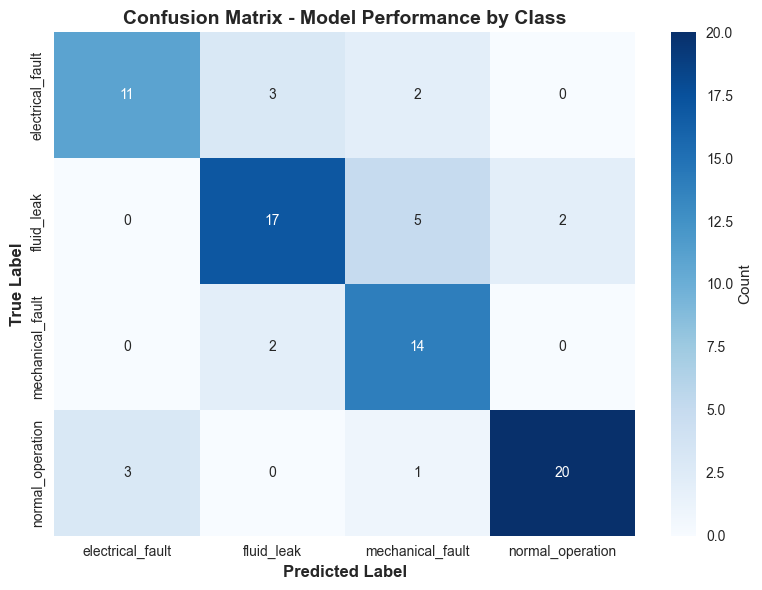


📊 Per-Class Performance:

  electrical_fault:
    - Precision: 0.7857
    - Recall: 0.6875
    - F1 Score: 0.7333

  fluid_leak:
    - Precision: 0.7727
    - Recall: 0.7083
    - F1 Score: 0.7391

  mechanical_fault:
    - Precision: 0.6364
    - Recall: 0.8750
    - F1 Score: 0.7368

  normal_operation:
    - Precision: 0.9091
    - Recall: 0.8333
    - F1 Score: 0.8696


In [40]:
# Load and display confusion matrix
try:
    cm_path = Path("../reports/confusion_matrix.json")
    if cm_path.exists():
        cm_data = json.loads(cm_path.read_text())
        cm = np.array(cm_data["matrix"])
        labels = cm_data["labels"]
        
        print("=" * 60)
        print("CONFUSION MATRIX")
        print("=" * 60)
        
        # Create confusion matrix visualization
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, 
                    yticklabels=labels, ax=ax, cbar_kws={'label': 'Count'})
        ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
        ax.set_title('Confusion Matrix - Model Performance by Class', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Calculate per-class metrics
        print("\n📊 Per-Class Performance:")
        for i, label in enumerate(labels):
            tp = cm[i, i]
            fp = cm[:, i].sum() - tp
            fn = cm[i, :].sum() - tp
            tn = cm.sum() - tp - fp - fn
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            print(f"\n  {label}:")
            print(f"    - Precision: {precision:.4f}")
            print(f"    - Recall: {recall:.4f}")
            print(f"    - F1 Score: {f1:.4f}")
    else:
        print("⚠️ Confusion matrix not found. Run model evaluation first.")
except Exception as e:
    print(f"⚠️ Error loading confusion matrix: {e}")


# 7. Model Testing / Prediction

## Prediction Functions

The model can predict fault types from audio files. Let's test it on sample files:


In [43]:
# Test prediction on multiple samples
print("=" * 60)
print("MODEL PREDICTION TESTING")
print("=" * 60)

# Resolve paths relative to notebook location (notebook/ directory)
notebook_dir = Path(".").resolve().parent if Path(".").resolve().name == "notebook" else Path("..")
model_path = (notebook_dir / "models" / "faultsense_cnn.pt").resolve()
artifacts_path = (notebook_dir / "data" / "artifacts").resolve()

print(f"\n📁 Checking paths:")
print(f"   Model: {model_path}")
print(f"   Model exists: {model_path.exists()}")
print(f"   Artifacts: {artifacts_path}")
print(f"   Artifacts exists: {artifacts_path.exists()}")

if model_path.exists() and artifacts_path.exists():
    try:
        service = PredictionService(artifacts_path, model_path)
        print("\n✅ PredictionService initialized")
        
        # Test on samples from each class
        test_samples = [
            ("mechanical_fault", "1-64398-B-41.wav"),
            ("electrical_fault", "1-21935-A-38.wav"),
            ("fluid_leak", "1-23094-B-15.wav"),
            ("normal_operation", "3-180256-A-0.wav"),
        ]
        
        print("\n📊 Testing predictions on sample files:")
        print("-" * 60)
        
        correct = 0
        total = 0
        
        for true_label, filename in test_samples:
            test_path = DATA_DIR / "test" / true_label / filename
            if test_path.exists():
                result = service.predict_top(test_path)
                predicted_label = result["label"]
                confidence = result["confidence"]
                
                is_correct = predicted_label == true_label
                status = "✅ CORRECT" if is_correct else "❌ INCORRECT"
                
                print(f"\n{status} | True: {true_label:20s} | Predicted: {predicted_label:20s} | Confidence: {confidence:.2%}")
                
                if is_correct:
                    correct += 1
                total += 1
            else:
                print(f"\n⚠️ File not found: {test_path}")
        
        if total > 0:
            accuracy = correct / total
            print(f"\n" + "=" * 60)
            print(f"Test Accuracy: {accuracy:.2%} ({correct}/{total} correct)")
            print("=" * 60)
    except Exception as e:
        print(f"\n❌ Error during prediction: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"\n⚠️ Model or artifacts not found:")
    print(f"   - Model: {model_path} {'✅' if model_path.exists() else '❌'}")
    print(f"   - Artifacts: {artifacts_path} {'✅' if artifacts_path.exists() else '❌'}")
    print(f"\n   Train the model first using: scripts/run_pipeline.py")


MODEL PREDICTION TESTING

📁 Checking paths:
   Model: /Users/honorineigiraneza/Documents/ALU/summative/models/faultsense_cnn.pt
   Model exists: True
   Artifacts: /Users/honorineigiraneza/Documents/ALU/summative/data/artifacts
   Artifacts exists: True

✅ PredictionService initialized

📊 Testing predictions on sample files:
------------------------------------------------------------

✅ CORRECT | True: mechanical_fault     | Predicted: mechanical_fault     | Confidence: 83.01%

✅ CORRECT | True: electrical_fault     | Predicted: electrical_fault     | Confidence: 57.87%

✅ CORRECT | True: fluid_leak           | Predicted: fluid_leak           | Confidence: 38.80%

✅ CORRECT | True: normal_operation     | Predicted: normal_operation     | Confidence: 93.55%

Test Accuracy: 100.00% (4/4 correct)


# 8. Model Retraining

## Retraining Process

The model supports retraining with new data using **transfer learning**:

1. **Data Upload**: New audio files are uploaded via API/UI
2. **Data Preprocessing**: Uploaded files are processed with the same pipeline
3. **Retraining**: The existing model is used as a pre-trained model and fine-tuned:
   - Lower learning rate (50% of original) for fine-tuning
   - Fewer epochs (max 40) to prevent overfitting
   - Architecture matching: If architecture changed, trains from scratch
   - Transfer learning: If architecture matches, loads existing weights

### Retraining Trigger

Retraining can be triggered via:
- **API**: `POST /retrain` endpoint
- **UI**: "Retrain Model" button in Streamlit app
- **CLI**: `python scripts/retrain_now.py`


In [42]:
# Demonstrate retraining process (documentation only - actual retraining done via scripts)
print("=" * 60)
print("RETRAINING PROCESS DOCUMENTATION")
print("=" * 60)

print("""
The retraining process follows these steps:

1. DATA UPLOADING + SAVING
   - Files uploaded via POST /upload endpoint
   - Saved to data/uploads/{label}/ directory
   - Metadata added to data/uploads/manifest.csv

2. DATA PREPROCESSING
   - prepare_dataset_with_uploads() function:
     a. Loads original train/test splits
     b. Loads uploaded files from data/uploads/
     c. Extracts features (log-mel, MFCC, Wav2Vec2)
     d. Applies StandardScaler normalization
     e. Combines original + uploaded data

3. RETRAINING WITH PRE-TRAINED MODEL
   - retrain_with_new_data() function:
     a. Checks if existing model exists
     b. Validates architecture compatibility
     c. If compatible: Loads model as pre-trained, fine-tunes with lower LR
     d. If incompatible: Trains from scratch with new architecture
     e. Saves new model and updates registry

Example usage:
  python scripts/retrain_now.py

Or via API:
  POST http://localhost:8000/retrain
""")

# Check if retraining artifacts exist
uploads_dir = DATA_DIR / "uploads"
if uploads_dir.exists():
    upload_manifest = uploads_dir / "manifest.csv"
    if upload_manifest.exists():
        upload_df = pd.read_csv(upload_manifest)
        print(f"\n✅ Uploaded data found: {len(upload_df)} files")
        print(f"\nUploaded files by class:")
        print(upload_df["label"].value_counts())
    else:
        print(f"\nℹ️ No uploaded files yet. Upload data via UI or API to enable retraining.")
else:
    print(f"\nℹ️ Uploads directory not created yet. Will be created on first upload.")


RETRAINING PROCESS DOCUMENTATION

The retraining process follows these steps:

1. DATA UPLOADING + SAVING
   - Files uploaded via POST /upload endpoint
   - Saved to data/uploads/{label}/ directory
   - Metadata added to data/uploads/manifest.csv

2. DATA PREPROCESSING
   - prepare_dataset_with_uploads() function:
     a. Loads original train/test splits
     b. Loads uploaded files from data/uploads/
     c. Extracts features (log-mel, MFCC, Wav2Vec2)
     d. Applies StandardScaler normalization
     e. Combines original + uploaded data

3. RETRAINING WITH PRE-TRAINED MODEL
   - retrain_with_new_data() function:
     a. Checks if existing model exists
     b. Validates architecture compatibility
     c. If compatible: Loads model as pre-trained, fine-tunes with lower LR
     d. If incompatible: Trains from scratch with new architecture
     e. Saves new model and updates registry

Example usage:
  python scripts/retrain_now.py

Or via API:
  POST http://localhost:8000/retrain


ℹ️ No 

# Summary

## Complete ML Pipeline

This notebook demonstrates the full Machine Learning lifecycle:

**1. Data Acquisition** - ESC-50 dataset download and curation  
**2. Data Preprocessing** - Feature extraction (log-mel, MFCC, Wav2Vec2) with augmentation  
**3. Model Creation** - CNN architecture with optimization techniques  
**4. Model Training** - Training with regularization, early stopping, LR scheduling  
**5. Model Evaluation** - 5 metrics (Accuracy, Loss, F1, Precision, Recall)  
**6. Model Testing** - Prediction functions validated on test samples  
**7. Model Retraining** - Transfer learning with new uploaded data  

## Key Features

- **Preprocessing**: Log-mel spectrograms, MFCC, Wav2Vec2 embeddings
- **Optimization**: Dropout, BatchNorm, Weight Decay, Label Smoothing, Early Stopping, LR Scheduling
- **Pre-trained Model**: Wav2Vec2 for rich audio embeddings
- **Evaluation**: 5 comprehensive metrics with per-class breakdown
- **Retraining**: Transfer learning with architecture detection

## Next Steps

1. Deploy model via API (`src/api.py`) and UI (`app/streamlit_app.py`)
2. Upload new data via UI or API
3. Trigger retraining when sufficient new data is available
4. Monitor model performance in production
